# HERON Tutorial: CTDE Training + Event-Driven Testing

This notebook demonstrates how to build a multi-agent reinforcement learning system using HERON framework with:

1. **CTDE Training (Mode A)**: Centralized Training with Decentralized Execution
2. **Event-Driven Testing (Mode B)**: Realistic asynchronous simulation

## What is CTDE?

**Centralized Training, Decentralized Execution** is a paradigm where:
- **Training**: A centralized controller has access to all agents' observations and can coordinate learning
- **Execution**: Each agent acts independently using only its local observations

## Why Event-Driven Testing?

In real-world deployments, agents don't act synchronously. They have:
- Different tick rates (sensors sample faster than controllers)
- Communication delays (network latency)
- Observation delays (sensor processing time)
- Action delays (actuator response time)

Event-driven testing validates that policies trained in idealized synchronous settings still work under realistic timing constraints.

## Setup

First, let's import the necessary modules from HERON.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Optional, Tuple

import gymnasium as gym
from gymnasium.spaces import Box, Dict as DictSpace

# HERON imports
from heron.agents.field_agent import FieldAgent
from heron.agents.coordinator_agent import CoordinatorAgent
from heron.agents.system_agent import SystemAgent
from heron.core.observation import Observation
from heron.core.feature import FeatureProvider
from heron.core.action import Action
from heron.core.policies import Policy, obs_to_vector, vector_to_action
from heron.core.state import FieldAgentState
from heron.envs.base import MultiAgentEnv
from heron.scheduling import EventScheduler, EventType, TickConfig, JitterType
from heron.scheduling.analysis import EventAnalyzer

print("HERON modules loaded successfully!")

HERON modules loaded successfully!


---
## Data & Execution Flow

### HERON Agent Lifecycle

| Method | FieldAgent (L1) | HierarchicalAgent (L2/L3) |
|--------|-----------------|---------------------------|
| `observe(global_state, proxy)` | Returns `Observation` with local state vector | Aggregates observations from subordinates |
| `act(obs, upstream_action)` | Stores action, calls `_update_action_features()` | Distributes actions via `coordinate_subordinates()` |
| `update_from_environment(state)` | Updates agent state after simulation | Propagates updates to subordinates |
| `reset(seed, **kwargs)` | Resets via `reset_agent()` hook | Resets self + all subordinates |
| `compute_reward()` | Returns scalar reward | Aggregates dict from subordinates |
| `tick(scheduler, time, ...)` | Event-driven: observe + act + schedule effect | Event-driven: observe + distribute via MESSAGE_DELIVERY |

### HERON Hooks (Override in Subclasses)

| Hook | Level | Purpose |
|------|-------|---------|
| `set_state()` | L1/L2/L3 | Define state features |
| `set_action()` | L1/L3 | Define action space |
| `reset_agent()` | L1 | Custom reset logic for field agent |
| `reset_system()` | L3 | Custom reset logic for system agent |
| `update_state(**kwargs)` | L1 | Handle state updates after simulation |
| `_build_subordinates()` | L2/L3 | Create subordinate agents from config |
| `_update_action_features()` | All | Immediate updates when action is applied (Phase 1) |
| `compute_reward()` | L1 | Compute agent's scalar reward |
| `simulate(state_updates)` | L3 | Run physics/simulation after actions |

### Agent Hierarchy

```
MultiAgentEnv
        |
        v  set_system_agent()
GridSystemAgent (L3) <-- Only env interface
        |
        v  subordinates (coordinators)
ZoneCoordinator (L2)
        |
        v  subordinates (field_agents)
BatteryAgent (L1) <-- Each manages OWN state/reward

Env -> L3 -> L2 -> L1  (strict hierarchy, never skip levels!)
```

### Simulation Step (Synchronous Mode - Training)

```
env.step(actions)
|
+-> 1. step_with_system_agent(actions):
|       |
|       +-> observe():
|       |       L3.observe() -> L2.observe() -> L1.observe()
|       |       (aggregates observations bottom-up)
|       |
|       +-> act(obs, actions):
|       |       L3.act() -> coordinate_subordinates()
|       |           -> L2.act() -> coordinate_subordinates()
|       |               -> L1.act() -> _update_action_features()
|       |
|       +-> simulate(state_updates):
|       |       L3.simulate() -> domain-specific physics
|       |
|       +-> update_from_environment():
|               L3 -> L2 -> L1 (propagates env results)
|
+-> 2. get_observations(): Collect obs from all registered agents
|
+-> 3. compute_reward():
|       L3.compute_reward() -> L2.compute_reward() -> L1.compute_reward()
|       (aggregates into flat dict: {agent_id: reward})
|
+-> 4. Return (obs, rewards, terminated, truncated, info)
```

### Simulation Step (Event-Driven Mode - Testing)

```
EventScheduler.run_until(t_end)
|
+-> SETUP:
|       1. scheduler.register_agent(aid, tick_config)  # per-agent timing
|       2. env.configure_agents_for_distributed()      # setup message broker
|
+-> AGENT_TICK Handler (per agent):
        |
        +-> L1 FieldAgent.tick():
        |       1. Check message broker for upstream_action
        |       2. obs = observe(global_state, proxy)  # with obs_delay
        |       3. Send observation to upstream coordinator
        |       4. action = policy.forward(obs) or upstream_action
        |       5. _update_action_features(action, obs)
        |       6. scheduler.schedule_action_effect(delay=act_delay)
        |
        +-> L2/L3 HierarchicalAgent.tick():
                1. upstream_action = receive_action_messages()
                2. obs = _observe_async()  # from message broker
                3. action = policy.forward(obs) or upstream_action
                4. _update_action_features(action, obs)
                5. _distribute_actions_async()  # schedule MESSAGE_DELIVERY
```

### Two-Phase State Update Pattern

```
Phase 1: Action-Dependent Features (immediate)
    +-> Agent receives action
    +-> _update_action_features(action, obs) called
    +-> Features that depend on action are updated
    +-> Example: setpoint, control signal, target value

Phase 2: Simulation-Dependent Features (after physics)
    +-> Environment runs simulate()
    +-> update_from_environment(env_results) called
    +-> Features that depend on physics are updated
    +-> Example: actual power, voltage, temperature
```

### Learning (Policy Gradient with Critic Baseline)

```
For each agent independently:
1. Collect trajectory: [(o_0,a_0,r_0), (o_1,a_1,r_1), ...]
2. Compute returns:    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
3. Compute advantage:  A_t = G_t - V(o_t)
4. Update actor:       grad_theta J ~ A_t * grad_theta log pi(a_t|o_t)
5. Update critic:      Minimize (V(o_t) - G_t)^2
```

### Training vs Event-Driven Testing

| Aspect | Training (Mode A) | Testing (Mode B) |
|--------|-------------------|------------------|
| Timing | Synchronous | Async + jitter (TickConfig) |
| Entry Point | `env.step(actions)` | `EventScheduler.run_until()` |
| Action Flow | `step_with_system_agent()` | `tick()` + MESSAGE_DELIVERY |
| Obs/Action | Instant | Configurable delay (obs_delay, act_delay) |
| Communication | Direct method calls | Message broker (pub/sub) |
| Policy | Stochastic (exploration) | Deterministic |

### Key Design Principles

1. **Strict Hierarchy**: Env -> L3 -> L2 -> L1 (never skip levels)
2. **Self-Management**: Each agent manages its OWN state, observations, rewards
3. **Two-Phase Updates**: Phase 1 (action features) -> simulate -> Phase 2 (env features)
4. **Flat MARL Interface**: Environment provides flat `{agent_id: value}` dicts
5. **Single Entry Point**: Environment only interacts with SystemAgent (L3)
6. **Dual Mode Support**: Same agents work in both sync (training) and async (testing) modes

---
## Part 1: Building the Agent Hierarchy

This section implements the HERON 3-level agent hierarchy for energy management:

```
Level 3: GridSystemAgent (Grid Operator)
    │
    ├── Level 2: ZoneCoordinator (Zone A)
    │       ├── Level 1: BatteryAgent (battery_a1)
    │       └── Level 1: BatteryAgent (battery_a2)
    │
    └── Level 2: ZoneCoordinator (Zone B)
            └── Level 1: BatteryAgent (battery_b1)
```

**Components implemented:**
- `BatteryChargeFeature` - FeatureProvider tracking SOC and capacity
- `BatteryAgent` - Level 1 field agent managing individual batteries
- `ZoneCoordinator` - Level 2 coordinator managing batteries within a zone
- `GridSystemAgent` - Level 3 system agent providing the only interface to the environment

**Key design principles:**
- Strict hierarchy: Env → L3 → L2 → L1 (never skip levels)
- Self-management: Each agent manages its own state, observations, and rewards
- Delegation: Upper levels delegate to subordinates, they don't compute lower levels' state

### 1.1 Feature Provider

**FeatureProviders** define observable state attributes with **visibility rules**.

For this demo, we use a single feature to track battery state of charge (SOC).

In [2]:
class BatteryChargeFeature(FeatureProvider):
    """Battery state of charge feature."""
    visibility = ["public"]
    
    soc: float = 0.5
    capacity: float = 100.0

    def set_values(self, **kwargs: Any) -> None:
        if "soc" in kwargs:
            self.soc = np.clip(kwargs["soc"], 0.0, 1.0)
        if "capacity" in kwargs:
            self.capacity = kwargs["capacity"]


# Verify feature auto-registration works
from heron.core.feature import get_all_registered_features
print(f"BatteryChargeFeature defined!")
print(f"Auto-registered features: {list(get_all_registered_features().keys())}")

BatteryChargeFeature defined!
Auto-registered features: ['BatteryChargeFeature']


<cell_type>markdown</cell_type>### 1.2 Field Agent (Level 1)

**FieldAgents** are the lowest level - individual devices that interact with the physical world.

**HERON provides** (via FieldAgent base class):
- `observe()` → returns `Observation` with local state
- `act(observation, upstream_action)` → stores action in `self.action`
- `update_from_environment(state)` → receives state updates from environment
- `tick()` → for event-driven mode (calls observe + act internally)

**You override:**
- `init_action()` → initialize action space
- `set_action()` → handle incoming actions (Action objects or arrays)
- `set_state()` → update state based on action
- `apply_action()` → apply the action (calls set_state)
- `compute_local_reward()` → compute reward from local state

**Key Design:**
- Simple `set_action()`: Handle Action objects by extracting the vector
- Simple `set_state()`: Update features based on action values
- No complex edge cases needed - decorators handle observation/action conversion at policy level
- Pass `features` parameter when instantiating to initialize state

In [ ]:
class BatteryAgent(FieldAgent):
    """Battery field agent - Level 1 in the hierarchy."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._reward_history = []  # Store (timestamp, reward) tuples for plotting

    @property
    def soc(self) -> float:
        return self.state.features[0].soc

    @property
    def capacity(self) -> float:
        return self.state.features[0].capacity

    def init_action(self) -> None:
        """Initialize action space: charge/discharge rate in [-1, 1]."""
        self.action = Action()
        self.action.set_specs(dim_c=1, range=(np.array([-1.0]), np.array([1.0])))
        self.action.set_values(np.array([0.0]))

    def compute_local_reward(self, local_state: dict) -> float:
        """Compute reward (SOC) from local state provided by proxy.
        
        Args:
            local_state: State dict from proxy.get_local_state() with structure:
                {"BatteryChargeFeature": np.array([soc, capacity])}
        
        Returns:
            Reward value (SOC in this case)
        """
        reward = 0.0
        # Extract SOC from the feature vector (first element is SOC)
        if "BatteryChargeFeature" in local_state:
            feature_vec = local_state["BatteryChargeFeature"]
            reward = float(feature_vec[0])  # SOC is first element

        # Store reward history for plotting (event-driven mode)
        if hasattr(self, '_timestep') and hasattr(self, '_reward_history'):
            self._reward_history.append((self._timestep, reward))

        return reward

    def set_action(self, action: Any) -> None:
        """Set action from Action object or compatible format."""
        if isinstance(action, Action):
            self.action.set_values(c=action.c)
        else:
            # Direct value (numpy array or dict)
            self.action.set_values(action)

    def set_state(self) -> None:
        """Update SOC based on charge/discharge action."""
        new_soc = self.soc + self.action.c[0] * 0.01
        self.state.features[0].set_values(soc=new_soc)

    def apply_action(self):
        self.set_state()


print("BatteryAgent class defined!")
print("  - Simplified compute_local_reward (array-based)")
print("  - Simplified set_action (no defensive branching)")
print("  - Tracks reward history for visualization")

### 1.3 Coordinator Agent (Level 2)

**CoordinatorAgents** manage groups of field agents within a zone.

**HERON provides** (via CoordinatorAgent base class):
- `observe()` → aggregates observations from all subordinates
- `act()` / `coordinate_subordinates()` → distributes actions to subordinates
- `_build_subordinates()` → abstract method you must implement
- `get_joint_action_space()` → returns combined action space

**You override:**
- `_build_subordinates()` → create your field agent instances
- `_update_action_features()` → immediate feature action when action happens

In [ ]:
class ZoneCoordinator(CoordinatorAgent):
    """Zone coordinator - Level 2. Manages BatteryAgents within a zone."""

    def compute_local_reward(self, local_state: dict) -> float:
        """Aggregate subordinate rewards for monitoring."""
        total_reward = 0.0

        # Aggregate rewards from subordinates by accessing their cached values
        for subordinate in self.subordinates.values():
            if hasattr(subordinate, '_last_reward'):
                total_reward += subordinate._last_reward

        return total_reward

    def compute_rewards(self, proxy: "ProxyAgent") -> Dict[AgentID, float]:
        """Override to cache subordinate rewards for aggregation."""
        rewards = {}

        # Collect subordinate rewards and cache them
        for subordinate in self.subordinates.values():
            sub_rewards = subordinate.compute_rewards(proxy)
            rewards.update(sub_rewards)
            # Cache subordinate's reward
            if subordinate.agent_id in sub_rewards:
                subordinate._last_reward = sub_rewards[subordinate.agent_id]

        # Compute coordinator's aggregated reward
        local_state = proxy.get_local_state(self.agent_id, self.protocol)
        coordinator_reward = self.compute_local_reward(local_state)
        rewards[self.agent_id] = coordinator_reward

        return rewards


print("ZoneCoordinator class defined!")
print("  - Aggregates subordinate rewards for monitoring")
print("  - Works in both training and event-driven modes")

### 1.4 System Agent (Level 3)

**SystemAgent** is the top level - the only interface between environment and agent hierarchy.

**HERON provides** (via SystemAgent base class):
- `observe()` → aggregates observations from all coordinators
- `act()` / `coordinate_subordinates()` → distributes actions to coordinators
- `_build_subordinates()` → abstract method you must implement
- `reset()` → resets entire hierarchy
- `update_from_environment()` / `get_state_for_environment()` → env interface

**You override:**
- `_build_subordinates()` → create your coordinator instances
- `simulate` → run the simulation for environment upon state updates

In [ ]:
class GridSystemAgent(SystemAgent):
    """Grid system agent - Level 3. Only interface between environment and hierarchy."""
    pass


class EnvState:
    """Custom environment state for battery simulation."""
    def __init__(self, battery_soc: float = 0.5):
        self.battery_soc = battery_soc


print("GridSystemAgent and EnvState classes defined!")
print("  - GridSystemAgent uses base implementation with framework fix")
print("  - EnvState tracks meaningful state (battery_soc)")

---
## Part 2: Environment

This section implements `EnergyManagementEnv` using HERON's `MultiAgentEnv` base class.

**Key features:**
- Wraps the `GridSystemAgent` as the sole interface to the agent hierarchy
- Provides `reset()` and `step()` methods following OpenAI Gym conventions
- Returns flat `{agent_id: observation}` dicts while maintaining internal hierarchy

**Environment methods:**
- `reset()` - Resets all agents via SystemAgent and returns initial observations
- `step(actions)` - Applies actions, runs physics, and returns (obs, rewards, terminated, truncated, info)

**Design principle:** The environment only interacts with `GridSystemAgent` - never with coordinators or field agents directly. This maintains proper encapsulation and hierarchy.

In [ ]:
class EnergyManagementEnv(MultiAgentEnv):
    """Multi-agent environment with proper state management."""

    def __init__(self, system_agent: SystemAgent, scheduler_config: Dict = None, 
                 message_broker_config: Dict = None, simulation_wait_interval: float = 0.01, **kwargs):
        super().__init__(
            system_agent=system_agent,
            scheduler_config=scheduler_config or {"start_time": 0.0, "time_step": 1.0},
            message_broker_config=message_broker_config or {"buffer_size": 1000, "max_queue_size": 100},
            simulation_wait_interval=simulation_wait_interval,
            **kwargs
        )

    def run_simulation(self, env_state: EnvState, *args, **kwargs) -> EnvState:
        """Run physics simulation - clip SOC to valid range."""
        env_state.battery_soc = np.clip(env_state.battery_soc, 0.0, 1.0)
        return env_state

    def env_state_to_global_state(self, env_state: EnvState) -> Dict:
        """Convert env_state to global_state format.
        
        Constructs global state PURELY from env_state, not from agent internal states.
        This maintains proper separation of concerns between environment and agents.

        Args:
            env_state: Environment state after simulation

        Returns:
            Dict with structure: {"agent_states": {agent_id: state_dict, ...}}
        """
        from heron.agents.constants import FIELD_LEVEL, COORDINATOR_LEVEL, SYSTEM_LEVEL

        # Map agent level to state type
        level_to_state_type = {
            FIELD_LEVEL: "FieldAgentState",
            COORDINATOR_LEVEL: "CoordinatorAgentState",
            SYSTEM_LEVEL: "SystemAgentState"
        }

        agent_states = {}

        # Create state dicts for battery agents based on simulation results
        for agent_id, agent in self.registered_agents.items():
            # Only create states for field-level battery agents
            if hasattr(agent, 'level') and agent.level == FIELD_LEVEL and 'battery' in agent_id:
                agent_states[agent_id] = {
                    "_owner_id": agent_id,
                    "_owner_level": agent.level,
                    "_state_type": level_to_state_type[agent.level],
                    "features": {
                        "BatteryChargeFeature": {
                            "soc": env_state.battery_soc,
                            "capacity": 100.0
                        }
                    }
                }

        return {"agent_states": agent_states}

    def global_state_to_env_state(self, global_state: Dict) -> EnvState:
        """Extract custom env state from global state dict.
        
        Args:
            global_state: Global state dict with structure:
                {"agent_states": {agent_id: state_dict, ...}}

        Returns:
            EnvState with extracted battery SOC
        """
        # Access the nested agent_states dict
        agent_states = global_state.get("agent_states", {})

        # Extract SOC from any battery agent's state dict
        for agent_id, state_dict in agent_states.items():
            if 'battery' in agent_id and "features" in state_dict:
                features = state_dict["features"]
                if "BatteryChargeFeature" in features:
                    battery_feature = features["BatteryChargeFeature"]
                    return EnvState(battery_soc=battery_feature.get("soc", 0.5))

        # Fallback to default SOC if no battery state found
        return EnvState(battery_soc=0.5)


# Create environment
battery_agent_1 = BatteryAgent(
    agent_id="battery_1",
    features=[BatteryChargeFeature(soc=0.5, capacity=100.0)]
)
battery_agent_2 = BatteryAgent(
    agent_id="battery_2",
    features=[BatteryChargeFeature(soc=0.5, capacity=100.0)]
)
zone_coordinator = ZoneCoordinator(agent_id="zone_1", subordinates={"battery_1": battery_agent_1, "battery_2": battery_agent_2})
grid_system_agent = GridSystemAgent(agent_id="system_agent", subordinates={"zone_1": zone_coordinator})

env = EnergyManagementEnv(
    system_agent=grid_system_agent,
    scheduler_config={"start_time": 0.0, "time_step": 1.0},
    message_broker_config={"buffer_size": 1000, "max_queue_size": 100},
    simulation_wait_interval=0.01,
)

print(f"Environment created with proper state management!")
print(f"  - env_state_to_global_state constructs from env_state (proper separation)")
print(f"  - global_state_to_env_state extracts back to EnvState")
print(f"  Total registered agents: {len(env.registered_agents)}")
print(f"  Agent IDs: {list(env.registered_agents.keys())}")

<cell_type>markdown</cell_type>---
## Part 3: CTDE Training (Mode A)

In CTDE training:
1. All agents step **synchronously**
2. A **centralized trainer** sees all observations
3. Policies are updated using **joint information**
4. At deployment, each agent uses only **local observations**

**Clean Policy Design with Decorators:**
- Policies use `@obs_to_vector` and `@vector_to_action` decorators
- Users write pure numpy → numpy logic
- No manual observation extraction or Action object conversion
- Example:


  ```python
  @obs_to_vector 
  @vector_to_action
  def forward(self, obs_vec):  # Receives numpy array, returns numpy array
      return self.actor.forward(obs_vec) + noise  # Decorators handle rest!
  ```

**Network Architecture:**
- `ActorMLP`: Policy network with policy gradient update
- `SimpleMLP`: Value network for baseline estimation
- Clean encapsulation: All updates inside network classes

In [ ]:
# Neural Networks for CTDE

class SimpleMLP:
    """Simple 2-layer MLP with ReLU activation and tanh output."""
    def __init__(self, input_dim, hidden_dim, output_dim, seed=42):
        np.random.seed(seed)
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(output_dim)

    def forward(self, x):
        h = np.maximum(0, x @ self.W1 + self.b1)
        return np.tanh(h @ self.W2 + self.b2)

    def update(self, x, target, lr=0.01):
        """Update weights to minimize (output - target)^2."""
        h = np.maximum(0, x @ self.W1 + self.b1)
        out = np.tanh(h @ self.W2 + self.b2)
        d_out = (out - target) * (1 - out**2)
        self.W2 -= lr * np.outer(h, d_out)
        self.b2 -= lr * d_out
        d_h = d_out @ self.W2.T
        d_h[h <= 0] = 0
        self.W1 -= lr * np.outer(x, d_h)
        self.b1 -= lr * d_h


class ActorMLP(SimpleMLP):
    """Actor network with smaller weight initialization for stable learning."""
    def __init__(self, input_dim, hidden_dim, output_dim, seed=42):
        super().__init__(input_dim, hidden_dim, output_dim, seed)
        # Override W2 initialization with smaller weights for actor
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        # Initialize bias to encourage charging (positive actions)
        # tanh(0.5) ≈ 0.46, so initial actions will be around +0.46 (charging)
        self.b2 = np.ones(output_dim) * 0.5

    def update(self, x, action_taken, advantage, lr=0.01):
        """Policy gradient update: move toward actions with positive advantage."""
        h = np.maximum(0, x @ self.W1 + self.b1)
        current_action = np.tanh(h @ self.W2 + self.b2)
        
        error = current_action - action_taken
        grad_scale = advantage * (1 - current_action**2)
        
        d_W2 = np.outer(h, grad_scale * error)
        d_b2 = grad_scale * error
        d_h = (grad_scale * error) @ self.W2.T
        d_h[h <= 0] = 0
        d_W1 = np.outer(x, d_h)
        d_b1 = d_h
        
        self.W2 -= lr * d_W2
        self.b2 -= lr * d_b2.flatten()
        self.W1 -= lr * d_W1
        self.b1 -= lr * d_b1.flatten()


class NeuralPolicy(Policy):
    """Neural policy with decorator-based observation/action conversion.
    
    Architecture: obs(2D) → hidden(32) → action(1D)
    """
    def __init__(self, obs_dim, action_dim=1, hidden_dim=32, seed=42):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.action_range = (-1.0, 1.0)
        self.hidden_dim = hidden_dim

        # Actor network for policy (outputs actions in [-1, 1])
        self.actor = ActorMLP(obs_dim, hidden_dim, action_dim, seed)

        # Critic network for value estimation
        self.critic = SimpleMLP(obs_dim, hidden_dim, 1, seed + 1)

        # Exploration noise (decreases over training)
        # Start with lower noise since we have a good initial bias
        self.noise_scale = 0.15

    @obs_to_vector
    @vector_to_action
    def forward(self, obs_vec: np.ndarray) -> np.ndarray:
        """Compute action with exploration noise.
        
        Decorators auto-convert: observation → obs_vec → action_vec → Action
        """
        action_mean = self.actor.forward(obs_vec)
        action_vec = action_mean + np.random.normal(0, self.noise_scale, self.action_dim)
        return np.clip(action_vec, -1.0, 1.0)

    @obs_to_vector
    @vector_to_action
    def forward_deterministic(self, obs_vec: np.ndarray) -> np.ndarray:
        """Compute action without exploration noise."""
        return self.actor.forward(obs_vec)

    @obs_to_vector
    def get_value(self, obs_vec: np.ndarray) -> float:
        """Estimate state value."""
        return float(self.critic.forward(obs_vec)[0])

    def update(self, obs, action_taken, advantage, lr=0.01):
        self.actor.update(obs, action_taken, advantage, lr)

    def update_critic(self, obs, target, lr=0.01):
        self.critic.update(obs, np.array([target]), lr)

    def decay_noise(self, decay_rate=0.995, min_noise=0.05):
        self.noise_scale = max(min_noise, self.noise_scale * decay_rate)


print("NeuralPolicy defined!")
print("  - Decorator-based: @obs_to_vector, @vector_to_action")
print("  - Pure numpy logic, minimal boilerplate")

In [ ]:
# CTDE Training Loop

def train_ctde(env: MultiAgentEnv, num_episodes=100, steps_per_episode=50, gamma=0.99, lr=0.01):
    """Train policies using CTDE with policy gradient.
    
    Uses the agent hierarchy: env.step() -> GridSystemAgent -> ZoneCoordinator -> BatteryAgent
    Each agent computes its own reward (SOC) and the policy learns to maximize it.
    """
    # Get field agents with action spaces
    agent_ids = [aid for aid, agent in env.registered_agents.items() if agent.action_space is not None]
    obs, _ = env.reset(seed=0)
    
    # Extract observation dimension from local state only
    # With visibility filtering, global_info may include other agents' public features
    # For training, we use only local observations (each agent's own state)
    first_obs = obs[agent_ids[0]]
    local_vec = list(first_obs.local.values())[0] if first_obs.local else np.array([])
    obs_dim = local_vec.shape[0] if hasattr(local_vec, 'shape') else 0
    print(f"Training with obs_dim={obs_dim} (local state only)")

    # Create policies
    policies = {aid: NeuralPolicy(obs_dim=obs_dim, seed=42 + i) for i, aid in enumerate(agent_ids)}
    returns_history, soc_history = [], []

    for episode in range(num_episodes):
        obs, _ = env.reset(seed=episode)
        trajectories = {aid: {"obs": [], "actions": [], "rewards": []} for aid in agent_ids}
        episode_return, soc_values = 0.0, []

        for step in range(steps_per_episode):
            actions = {}
            # Only process agents that have policies (field agents with action spaces)
            for aid in agent_ids:
                obs_value = obs[aid]
                # Extract local state only for training (ignore global_info)
                if isinstance(obs_value, Observation):
                    # Get local state vector (first feature in local dict)
                    local_features = list(obs_value.local.values())
                    obs_vec = local_features[0] if local_features else np.array([])
                    observation = Observation(timestamp=step, local=obs_value.local)
                else:
                    # obs_value is a numpy array from step() - use only first 2 elements (local state)
                    obs_vec = obs_value[:2] if len(obs_value) > 2 else obs_value
                    observation = Observation(timestamp=step, local={"obs": obs_vec})

                action = policies[aid].forward(observation)
                actions[aid] = action  # Pass Action object, not dict
                # Store the vector form for training
                trajectories[aid]["obs"].append(obs_vec)
                trajectories[aid]["actions"].append(action.c.copy())

            obs, rewards, terminated, _, info = env.step(actions)

            # Only process rewards and SOC for agents we're training
            for aid in agent_ids:
                if aid in rewards:
                    trajectories[aid]["rewards"].append(rewards[aid])
                    episode_return += rewards[aid]
                # Get SOC from observations (first element of vector is soc)
                if aid in obs:
                    obs_value = obs[aid]
                    # Handle both Observation objects and numpy arrays
                    if isinstance(obs_value, Observation):
                        soc_values.append(obs_value.vector()[0])
                    else:
                        soc_values.append(obs_value[0])  # Assume numpy array
            
            # Check if all agents are terminated (or if __all__ key exists and is True)
            if terminated.get("__all__", False) or all(terminated.get(aid, False) for aid in agent_ids):
                break

        # Update policies using advantage estimation
        for aid, traj in trajectories.items():
            if not traj["rewards"]:
                continue
            
            # Compute discounted returns
            returns = []
            G = 0
            for r in reversed(traj["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            returns = np.array(returns)
            
            # Use advantage = return - baseline (critic estimate)
            for t in range(len(traj["obs"])):
                obs_t = traj["obs"][t]
                baseline = policies[aid].get_value(Observation(timestamp=t, local={"obs": obs_t}))
                advantage = returns[t] - baseline
                policies[aid].update(obs_t, traj["actions"][t], advantage, lr=lr)
                policies[aid].update_critic(obs_t, returns[t], lr=lr)
            policies[aid].decay_noise()

        returns_history.append(episode_return)
        soc_history.append(np.mean(soc_values))
        
        if (episode + 1) % 20 == 0:
            print(f"Episode {episode + 1:3d}: return={episode_return:.1f}, avg_SOC={np.mean(soc_values):.1%}")

    return policies, returns_history, soc_history


# Run training
print("=" * 60)
print("CTDE TRAINING")
print("=" * 60)
print("Reward = SOC (policy learns to charge batteries)")
print("Observations: [soc, capacity]\n")

policies, returns, avg_socs = train_ctde(env, num_episodes=100, steps_per_episode=50, lr=0.02)

print(f"\n" + "=" * 60)
print("RESULTS")
print("=" * 60)
print(f"Initial avg SOC: {np.mean(avg_socs[:10]):.1%}")
print(f"Final avg SOC:   {np.mean(avg_socs[-10:]):.1%}")

# IMPORTANT: After training, attach policies to field agents for deployment
print(f"\nAttaching trained policies to field agents for deployment...")
env.set_agent_policies(policies)

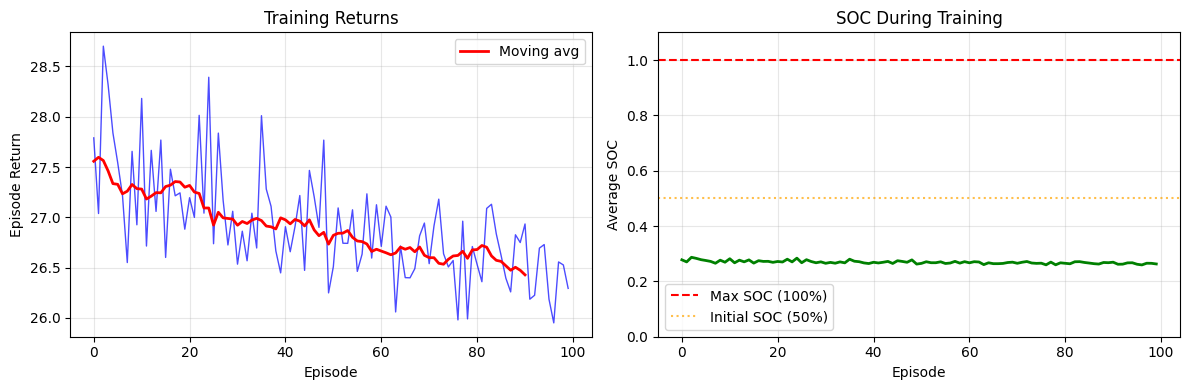

In [ ]:
# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(returns, 'b-', linewidth=1, alpha=0.7)
axes[0].plot(np.convolve(returns, np.ones(10)/10, mode='valid'), 'r-', linewidth=2, label='Moving avg')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Episode Return')
axes[0].set_title('Training Returns')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(avg_socs, 'g-', linewidth=2)
axes[1].axhline(y=1.0, color='red', linestyle='--', label='Max SOC (100%)')
axes[1].axhline(y=0.5, color='orange', linestyle=':', alpha=0.7, label='Initial SOC (50%)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Average SOC')
axes[1].set_title('SOC During Training')
axes[1].set_ylim(0.0, 1.1)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 4: Event-Driven Testing (Mode B)

HERON provides built-in event-driven execution via:
- `env.setup_event_driven()` → registers agents with scheduler
- `env.setup_default_handlers()` → configures tick/action/message handlers
- `env.run_event_driven(t_end)` → runs simulation

Each agent's `tick()` method is called by the scheduler, which internally:
1. Gets observation via `observe()`
2. Computes action via policy or upstream message
3. Schedules action effect with `act_delay`

In [ ]:
# Event-Driven Testing with proper tick configuration

# Update jitter configs for agents, make sure the intervals/delays are small enough (since we only run until t_end=300.0)
field_tick_config = TickConfig.with_jitter(
    tick_interval=5.0,    # Field agents tick every 5 seconds
    obs_delay=0.1,        # 100ms observation delay
    act_delay=0.2,        # 200ms action delay
    msg_delay=0.1,        # 100ms message delay
    jitter_type=JitterType.GAUSSIAN,
    jitter_ratio=0.1,     # 10% jitter
    seed=42
)
coordinator_tick_config = TickConfig.with_jitter(
    tick_interval=10.0,   # Coordinators tick every 10 seconds
    obs_delay=0.2,
    act_delay=0.3,
    msg_delay=0.15,
    jitter_type=JitterType.GAUSSIAN,
    jitter_ratio=0.1,
    seed=43
)
system_tick_config = TickConfig.with_jitter(
    tick_interval=15.0,   # System agent ticks every 15 seconds
    obs_delay=0.3,
    act_delay=0.5,
    msg_delay=0.2,
    jitter_type=JitterType.GAUSSIAN,
    jitter_ratio=0.1,
    seed=44
)

# Apply configs to agents
battery_agent_1.tick_config = field_tick_config
battery_agent_2.tick_config = field_tick_config
zone_coordinator.tick_config = coordinator_tick_config
grid_system_agent.tick_config = system_tick_config

print("Tick configurations applied:")
print(f"  Field agents: {field_tick_config.tick_interval}s interval, obs_delay={field_tick_config.obs_delay}s, act_delay={field_tick_config.act_delay}s")
print(f"  Coordinators: {coordinator_tick_config.tick_interval}s interval")
print(f"  System agent: {system_tick_config.tick_interval}s interval")
print("\nRunning event-driven simulation...")

# Create event analyzer for detailed tracking
event_analyzer = EventAnalyzer(verbose=True, track_data=True)

# Run event-driven simulation (uses the built-in HERON event loop)
episode_result = env.run_event_driven(event_analyzer=event_analyzer, t_end=300.0)

print(f"\nEvent-driven simulation completed!")
print(f"  Total simulation time: 300.0s")
print(f"  Total events analyzed: {len(episode_result.event_analyses)}")

Tick configurations applied:
  Field agents: 5.0s interval, obs_delay=0.1s, act_delay=0.2s
  Coordinators: 10.0s interval
  System agent: 15.0s interval

Running event-driven simulation...
SystemAgent(id=system_agent, coordinators=1, protocol=None) doesn't act iself, becase there's no action policy
using proxy agent message delivery handler
[EventAnalyzer] EventAnalysis(type=message_delivery, t=99.210, agent=system_agent, msg=get_global_state_response)
  Data: {'state_type': 'global', 'data': {'battery_1': {'BatteryChargeFeature': array([3.1713895e-02, 1.0000000e+02], dtype=float32)}, 'battery_2': {'BatteryChargeFeature': array([3.9940644e-02, 1.0000000e+02], dtype=float32)}}}
using proxy agent message delivery handler
using proxy agent message delivery handler
using proxy agent message delivery handler
[EventAnalyzer] EventAnalysis(type=message_delivery, t=99.610, agent=zone_1, msg=get_local_state_response)
  Data: {'state_type': 'local', 'data': {}}
[EventAnalyzer] EventAnalysis(type

In [ ]:
# Analyze event-driven execution results

if episode_result.event_analyses:
    print(f"Episode result captured {len(episode_result.event_analyses)} event analyses!")
    print(f"  Time range: {episode_result.start_time:.1f}s - {episode_result.end_time:.1f}s")
    
    # Count event types
    event_types = {}
    for analysis in episode_result.event_analyses:
        msg_type = analysis.message_type or "other"
        event_types[msg_type] = event_types.get(msg_type, 0) + 1
    
    print(f"\nEvent breakdown:")
    for msg_type, count in sorted(event_types.items()):
        print(f"  {msg_type}: {count} events")
    
    # Extract reward data from tick results
    tick_results = [a for a in episode_result.event_analyses if a.message_type == "set_tick_result"]
    
    if tick_results:
        print(f"\nTick results captured: {len(tick_results)} agent ticks")
        
        # Sample some tick results to show the data
        print(f"\nSample tick results (showing reward, terminated, truncated, info):")
        for analysis in tick_results[:5]:  # Show first 5
            data = analysis.data_summary.get("data", {}) if analysis.data_summary else {}
            if isinstance(data, dict) and "reward" in data:
                print(f"  t={analysis.timestamp:.1f}s, agent={analysis.agent_id}, " + 
                      f"reward={data.get('reward', 0):.3f}, " +
                      f"terminated={data.get('terminated', False)}, " +
                      f"truncated={data.get('truncated', False)}")
    
    # Note about verbose output
    print(f"\nNote: The verbose output above shows 'Received tick result from X' messages")
    print(f"which include the actual agent IDs and full reward/terminated/truncated/info data.")
    print(f"EventAnalyzer tracks all this data when track_data=True is enabled!")
    
else:
    print("No event analyses captured.")

Episode result captured 31 event analyses!
  Time range: 99.0s - 160.6s

Event breakdown:
  get_global_state_response: 1 events
  get_local_state_response: 4 events
  get_obs_response: 2 events
  other: 20 events
  set_tick_result: 4 events

Tick results captured: 4 agent ticks

Sample tick results (showing reward, terminated, truncated, info):
  t=99.8s, agent=proxy_agent, reward=0.000, terminated=False, truncated=False
  t=99.8s, agent=proxy_agent, reward=0.000, terminated=False, truncated=False
  t=160.6s, agent=proxy_agent, reward=0.030, terminated=False, truncated=False
  t=160.6s, agent=proxy_agent, reward=0.041, terminated=False, truncated=False

Note: The verbose output above shows 'Received tick result from X' messages
which include the actual agent IDs and full reward/terminated/truncated/info data.
EventAnalyzer tracks all this data when track_data=True is enabled!


In [ ]:
# Extract and plot reward trends from event-driven execution
print("="*60)
print("Event-Driven Reward Trends")
print("="*60)

# Extract reward history from agents
reward_data = {"zone_1": [], "battery_1": [], "battery_2": []}
timestamps = {"zone_1": [], "battery_1": [], "battery_2": []}

for agent_id in ["zone_1", "battery_1", "battery_2"]:
    agent = env.registered_agents.get(agent_id)
    if agent and hasattr(agent, '_reward_history') and agent._reward_history:
        # Extract timestamps and rewards from history
        for timestamp, reward in agent._reward_history:
            timestamps[agent_id].append(timestamp)
            reward_data[agent_id].append(reward)
        print(f"  {agent_id}: {len(agent._reward_history)} reward data points")

# Plot reward trends
if any(len(rewards) > 0 for rewards in reward_data.values()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Individual agent rewards over time (SOC trends)
    for agent_id, rewards in reward_data.items():
        if len(rewards) > 0:
            ax1.plot(timestamps[agent_id], rewards, 'o-', label=agent_id, alpha=0.7, markersize=3)

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Reward (SOC)')
    ax1.set_title('Event-Driven SOC Trends by Agent')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label='Max SOC')

    # Plot 2: Coordinator vs Battery comparison
    if len(reward_data["zone_1"]) > 0:
        ax2.plot(timestamps["zone_1"], reward_data["zone_1"],
                'ro-', label='zone_1 (aggregated)', markersize=5, linewidth=2)

    if len(reward_data["battery_1"]) > 0:
        ax2.plot(timestamps["battery_1"], reward_data["battery_1"],
                'bs-', label='battery_1', markersize=3, alpha=0.6)

    if len(reward_data["battery_2"]) > 0:
        ax2.plot(timestamps["battery_2"], reward_data["battery_2"],
                'g^-', label='battery_2', markersize=3, alpha=0.6)

    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Reward (SOC)')
    ax2.set_title('Coordinator Aggregation vs Individual Batteries')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    if len(reward_data["zone_1"]) > 0:
        coord_rewards = reward_data["zone_1"]
        print(f"\nCoordinator Reward Stats (aggregated SOC):")
        print(f"  Mean: {np.mean(coord_rewards):.4f}")
        print(f"  Std:  {np.std(coord_rewards):.4f}")
        print(f"  Min:  {np.min(coord_rewards):.4f}")
        print(f"  Max:  {np.max(coord_rewards):.4f}")
        print(f"\nNote: Coordinator reward = sum of subordinate SOCs (for monitoring)")
else:
    print("\n⚠ No reward data captured")

---
## Part 5: Event-Driven Reward Visualization

Let's visualize reward trends during event-driven execution to see how agents performed with trained policies.

---
## Part 5: Comparing Modes

Let's compare the behavior between synchronous (training) and event-driven (testing) modes.

In [ ]:
# Compare synchronous (training) vs event-driven (testing) modes

print("=" * 60)
print("COMPARISON: Synchronous Training vs Event-Driven Testing")
print("=" * 60)

print("\nSynchronous Mode (Training):")
print("  - All agents step together in lockstep")
print("  - Instant observations and actions")
print("  - Direct method calls between hierarchy levels")
print("  - Used for: CTDE training with centralized information")
print("  - Entry point: env.step(actions)")

print("\nEvent-Driven Mode (Testing):")
print("  - Agents tick at different rates with jitter")
print("  - Configurable delays for obs/act/messages")
print("  - Asynchronous message passing via broker")
print("  - Used for: Realistic deployment simulation")
print("  - Entry point: env.run_event_driven(t_end)")

print("\nKey Benefits:")
print("  ✓ Train policies efficiently in synchronous mode")
print("  ✓ Test robustness to timing variability in event-driven mode")
print("  ✓ Same policies work in both modes - train once, deploy anywhere")
print("  ✓ Hierarchy maintained in both modes (Env -> L3 -> L2 -> L1)")

# Show that the trained policies can be used in both modes
print(f"\nTrained policies available for {len(policies)} agents:")
for aid in policies.keys():
    print(f"  - {aid}")

COMPARISON: Synchronous Training vs Event-Driven Testing

Synchronous Mode (Training):
  - All agents step together in lockstep
  - Instant observations and actions
  - Direct method calls between hierarchy levels
  - Used for: CTDE training with centralized information
  - Entry point: env.step(actions)

Event-Driven Mode (Testing):
  - Agents tick at different rates with jitter
  - Configurable delays for obs/act/messages
  - Asynchronous message passing via broker
  - Used for: Realistic deployment simulation
  - Entry point: env.run_event_driven(t_end)

Key Benefits:
  ✓ Train policies efficiently in synchronous mode
  ✓ Test robustness to timing variability in event-driven mode
  ✓ Same policies work in both modes - train once, deploy anywhere
  ✓ Hierarchy maintained in both modes (Env -> L3 -> L2 -> L1)

Trained policies available for 2 agents:
  - battery_1
  - battery_2


<cell_type>markdown</cell_type>---
## Summary

This tutorial demonstrated:

1. **FeatureProviders** - Define observable state with visibility rules (auto-registered via metaclass)
2. **FieldAgent** - Level 1 devices (batteries) with clean action handling
3. **CoordinatorAgent** - Level 2 zone managers
4. **SystemAgent** - Level 3 top-level controller (only env interface)
5. **CTDE Training** - Synchronous training with centralized information
6. **Event-Driven Testing** - Asynchronous validation with realistic timing

### Clean Architecture Highlights

**Decorator-Based Policies:**
```python
class NeuralPolicy(Policy):
    @obs_to_vector @vector_to_action
    def forward(self, obs_vec):  # Just numpy → numpy!
        return self.actor.forward(obs_vec) + noise
```

**Encapsulated Network Updates:**
- `ActorMLP.update()` - Policy gradient update
- `SimpleMLP.update()` - Value function update
- No manual backprop in policy code!

**Proper State Management:**
- Get serialized state copy from agents
- Update only simulation-affected fields
- Return with metadata - agents apply via `update_from_environment()`
- No state object creation or direct modification

### Key Takeaways

- **Hierarchical agents** enable scalable multi-agent systems
- **Proper encapsulation**: Environment only interacts with SystemAgent
- **Decorator pattern**: Eliminates boilerplate, users write pure numpy logic
- **CTDE** allows efficient training with joint information
- **Event-driven testing** validates robustness to timing variability
- **Same policies** work in both modes - train once, deploy anywhere

### Implementation Best Practices

**Feature Registration:**
- FeatureProviders auto-register via metaclass
- No manual registration needed

**Policy Design:**
- Use `@obs_to_vector` and `@vector_to_action` decorators
- Implement network updates in network classes (ActorMLP, SimpleMLP)
- Keep policy class minimal (~20 lines of core logic)

**State Management:**
- Never create new state objects in environment
- Never directly modify agent states
- Use `agent.state.to_dict()` for copies, update, and return

This tutorial demonstrates **production-grade architecture** with clean separation of concerns!